## Load modules

We use matplotlib for graphs, scipy and numpy for statistical functions and random distributions, and pyabc for inferring parameter sets. We additionally use line_profiler and memory_profiler to measure code performance.

In [1]:
import os
import tempfile

db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))

In [2]:
#import modules, which consist of python command
import copy, random, functools, pickle, math
import numpy as np
import pandas as pd
from multiprocessing import Pool
from scipy import stats
from functools import partial

In [3]:
%matplotlib inline

from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition,
                   AdaptivePNormDistance)
from pyabc.visualization import plot_kde_2d
import matplotlib.pyplot as plt
import scipy as sp

/home/hz368/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/hz368/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
#load extensions
%load_ext line_profiler
%load_ext memory_profiler

In [5]:
def getLineage(filename):
    #reads a tsv file of clone counts
    df = pd.read_csv(filename, sep="\t")
    counts = np.transpose(df.values).astype(float)
    header = df.columns.values
    return(header[1:].astype(float),counts[1:])

In [6]:
times, counts = getLineage("DoupeAggregate.tsv")

In [7]:
times

array([  3.,  10.,  21.,  42.,  84., 180., 365.])

In [8]:
counts

array([[ 90.,  43.,   4., ...,   0.,   0.,   0.],
       [ 96., 102.,  34., ...,   0.,   0.,   0.],
       [140.,  79.,  38., ...,   0.,   0.,   0.],
       ...,
       [ 83.,  77.,  38., ...,   0.,   0.,   0.],
       [ 40.,  59.,  43., ...,   0.,   0.,   0.],
       [ 12.,  18.,  15., ...,   0.,   0.,   1.]])

In [9]:
[np.where(counts[n] > 0) for n in range(len(counts))]

[(array([0, 1, 2, 3]),),
 (array([0, 1, 2, 3, 4, 5]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7, 10]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 12, 13, 19, 27]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         19, 21, 25, 28]),),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 26, 29, 32, 33, 34, 35, 36, 38, 49,
         55, 84, 89]),),
 (array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,
          40,  41,  42,  43,  44,  46,  47,  48,  53,  54,  57,  59,  61,
          62,  69,  74,  79,  84,  95, 109, 129, 139, 174]),)]

In [10]:
# the maximum clone size is(4,6,11,28,29,90,175)

### Exploring the data

We showed that the simulations showed a linear growth in average clone size over time. Here we repeat the test on the experimental data.

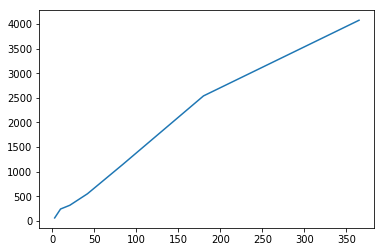

In [11]:
averageClones = [ sum([size*number for (size,number) in enumerate(t)])  for t in counts] 
plt.plot(times,averageClones)

In [12]:
from mpmath import *
import cmath

In [13]:
import math
def normal_round(n):
    if n - math.floor(n) < 0.5:
        return math.floor(n)
    return math.ceil(n)

In [14]:
def F(x, y, t, r, gamma):
#     v = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5)
    v = (1 - 4 * r)** 0.5    
#     w = (gamma * (1 - 2 * r) - 2 * r) / scipy.linalg.fractional_matrix_power(
#         2 * gamma * (1 - 4 * r), 0.5)
    w = (gamma * (1 - 2 * r) - 2 * r) / (2 * gamma * (1 - 4 * r)** 0.5)    
#     gg = scipy.linalg.fractional_matrix_power(1 - 4 * r, 0.5) / gamma
    gg = (1 - 4 * r)** 0.5 / gamma
    u = (1 - y) * np.exp(-gamma * t)
    u0 = (1 - y)
    Q = 1 + 2 * w - gg * u0 + (2 * r * (x - y) + y - 1) / gamma
    C = (-Q * whitm(w, 0, gg * u0) + (1 + 2 * w) * whitm(1 + w, 0, gg * u0)) / \
        (Q * whitw(w, 0, gg * u0) + 2 * whitw(1 + w, 0, gg * u0))
    f = 1 - u + \
        (u * (1 + v) - gamma * (1 + 2 * w)) / (2 * r) + \
        (gamma / (2 * r)) * ((1 + 2 * w) * whitm(1 + w, 0, u * gg) -
                             2 * C * whitw(1 + w, 0, u * gg)) / \
        (whitm(w, 0, u * gg) + C * whitw(w, 0, u * gg))
    return f


def Antal(z, t, r, gamma):
    g = []
    for k in range(len(z)):
        if z[k] == 1:
            g.append(1)
        else:
            g.append(F(z[k], z[k], t, r, gamma))
            
#     for k in range(1, len(z) + 1):
#         if z[k] == 1:
#             g[k] = 1
#         else:
#             g[k] = F(z[k], z[k], t, r, gamma)

    return g

In [15]:
def Psurv(t, l, r, rho):
    rho = rho - 0.00001
    gamma = rho / (1 - rho)
    T = l * t
    p = 1 - np.real(Antal([0], T, r, gamma))
#     if (p <= 0 or p > 1 or np.isnan(p)):
    if (p <= 0 or p > 1):
        p = Psurv(t, l, r + 0.00001, rho - 0.001)
    return p

In [16]:
def Pn(n, t, l, r, rho, N, returnConsecutive='', max_n=''):
    if max(n) >= N:
        N = max(n) + 1
    rho = rho - 0.00001
    assert (rho < 1)
    assert (rho > 0)
    gamma = rho / (1 - rho)
    T = l * t
#     k = range(N)
#     Gvals = Antal(cmath.exp(2 * np.pi * 1j * k / N), T, r, gamma)
    Gvals = Antal([cmath.exp(2 * np.pi * 1j * k / N) for k in range(int(N))], T, r, gamma)
    p = []

    if returnConsecutive:
        p = np.zeros(max_n)
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#              p[n[lp]] = \
#                 np.real((1 / N) *
#                         sum(Gvals * np.exp(-2 * np.pi * 1j * k * n[lp] / N)))
            temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[n[lp]-1] = np.real((1 / N) *sum([a*b for a,b in zip(Gvals,temporary)]))
                               
    else:
#         for lp in range(1, len(n) + 1):
        for lp in range(len(n)):
#             p[lp] = \
#                 np.real((1 / N) * sum(Gvals *
#                                       np.exp(-2 * np.pi * 1j * k * n[lp] / N)))          
            Temporary = [cmath.exp(-2 * np.pi * 1j * k * n[lp] / N) for k in range(int(N))]
            p[lp] = np.real((1 / N) * sum(a*b for a,b in zip(Gvals,Temporary)))
#     print(Gvals)
    tst = sum(p)
#     print(tst)
    if (tst > 1 or tst < 0 or np.isnan(tst)):
        print('Pathological point: r=' + str(r) + ' rho=' + str(
            rho) + '. Making 0.1% perturbation')
        p = Pn(n, t, l, r + 0.00001, rho - 0.001, N, returnConsecutive, max_n)

#     for x in range(len(p)):
#         if (p[x] < 0):
#             p[x] = 0

#     p[p < 0 & p > -1e-5] = 0

    return(p)

In [17]:
def logLikelihood(obs,lpBins,binSize):
    maxClone = len(lpBins)
    def noisyMul(a,b,i):
        #print("logP",lp, "\nobsv", obs); lp[i]*obs[i]
        print("logP",a, "\nobsv", b)
        return(a[i]*b[i])
    obsBins = [sum(obs[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))]
    return(sum([obsBins[j]*lpBins[j] for j in range(maxClone)]))

def allLogLike(obs,lpBins,binSize):
    return(sum([logLikelihood(o,p,binSize) for o,p in zip(obs,lpBins)]))

def logProbability(probability,binSize):
    binSizeList = [[sum(t[sum(binSize[0:n]):sum(binSize[0:(n+1)])]) for n in range(len(binSize))] for t in probability]
    logFreq = [[0 if n==0 else math.log10(n) for n in t] for t in binSizeList]
    return(logFreq)

def calculateLikelihood(probability,binSize,data):
    lpBins = logProbability(probability, binSize)
    like = allLogLike(data,lpBins,binSize)
    #print(like)
    return(like)

In [18]:
def main(t,nRange,lambdaRange,rRange,binSize,data):
    maxN = max(list(map(max, nRange)))
    PScanPP = [[[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))] for L1 in range(len(lambdaRange))]    
    PSurvScanPP = [[np.zeros(len(nRange)) for L3 in range(len(rRange))] for L1 in range(len(lambdaRange))]
    timePoints = range(len(t))
    nBadValues = 0

    for L1 in range(len(lambdaRange)):       
        PScanPP_local = [[np.zeros(maxN) for L4 in range(len(nRange))] for L3 in range(len(rRange))]             
#         PSurvScanPP_local = [np.zeros(len(nRange)) for L3 in range(len(rRange))]
        for L3 in range(len(rRange)):
            for L4 in timePoints:
                rho = rRange[L3]/0.12
                probS = Psurv(t[L4], lambdaRange[L1], rRange[L3], rho)
                avgN = 1 / probS
                Niter = max([normal_round(int(4*avgN)), normal_round(1.5*max(nRange[L4])), 10])
                probN = Pn(nRange[L4], t[L4], lambdaRange[L1], rRange[L3], rho, Niter, 'returnConsecutive', maxN)
                if any(probN > 1) or \
                        sum(probN) > 1 or \
                        probS > 1 or \
                        probS <0 or \
                        abs(probS-sum(probN))>1e-3:
                    print('Bad values at time t=' + str(t[L4]) + ' lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rho) + ' r=' + str(rRange[L3]))
                    print('any(probN>1=' + str(any(probN>1)) + ', sum(probN)>1=' + str(sum(probN)>1) + ', (probS-sum(probN))=' + str(probS-sum(probN)))
                    nBadValues += 1
                else:
                    print('Completed time t=' + str(t[L4]) + ' weeks, lambda=' + str(lambdaRange[L1]) + ' rho=' + str(rho) + ' r=' + str(rRange[L3]))
#                 PSurvScanPP_local[L3][L4] = probS
#                 PScanPP_local[L3][L4][:] = probN
                PScanPP_local[L3][L4][:] = probN/probS
            PScanPP_local[L3] = calculateLikelihood(PScanPP_local[L3],binSize,data)
#         PSurvScanPP[L1] = PSurvScanPP_local
        PScanPP[L1] = PScanPP_local

    return(PScanPP) 

In [19]:
# PScan(L1,L2,L3,L4,:)/PSurvScan(L1,L2,L3,L4)

In [20]:
nSize = len(np.transpose(counts))
nBin = int(round(np.log(nSize)/np.log(2)+0.5))
binSize = np.append([1],[2**(n-1) for n in range(1,(nBin+1))])


In [21]:
# example:t = [10 / 7, 30 / 7, 84 / 7, 26]
t = times/7
# example: nRange = [list(range(1, 8)),list(range(1, 14)),list(range(1, 27)),list(range(1, 56))]
# For Doupe data, the maximum clone size is(4,6,11,28,29,90,175)
nRange = [list(range(1,4)),list(range(1,6)),list(range(1,11)),list(range(1,28)),list(range(1,29)),list(range(1,90)),list(range(1,175))]
lambdaRange = [1.9]
bins=500
rRange = [(i*0.1/bins) for i in range(1, bins)]
%time result = main(t,nRange,lambdaRange,rRange,binSize,counts)

Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.0016666666666666668 r=0.0002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.04942205934418642')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.0016666666666666668 r=0.0002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.13782346232232445')]
Bad values at time t=3.0 lambda=1.9 rho=0.0016666666666666668 r=0.0002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.062642540904416566')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.0016666666666666668 r=0.0002
Bad values at time t=12.0 lambda=1.9 rho=0.0016666666666666668 r=0.0002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.14083970492835451')]
Bad values at time t=25.714285714285715 lambda=1.9 rho=0.0016666666666666668 r=0.0002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015924251150021274')]
Bad values at time t=52.142857142857146 lambda=1.9 rho=0.0016666666666666668 r=0.0002


Completed time t=6.0 weeks, lambda=1.9 rho=0.013333333333333334 r=0.0016
Bad values at time t=12.0 lambda=1.9 rho=0.013333333333333334 r=0.0016
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.058213049350308466')]
Bad values at time t=25.714285714285715 lambda=1.9 rho=0.013333333333333334 r=0.0016
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015944421181877111')]
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.013333333333333334 r=0.0016
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.015 r=0.0018
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.048803319374121856')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.015 r=0.0018
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.13087893805275364')]
Bad values at time t=3.0 lambda=1.9 rho=0.015 r=0.0018
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.053097581741557209')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.01

Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.02666666666666667 r=0.0032
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.028333333333333335 r=0.0034000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0481800668429746')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.028333333333333335 r=0.0034000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.12418587945652915')]
Bad values at time t=3.0 lambda=1.9 rho=0.028333333333333335 r=0.0034000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045310595791228092')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.028333333333333335 r=0.0034000000000000002
Bad values at time t=12.0 lambda=1.9 rho=0.028333333333333335 r=0.0034000000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034935088735918662')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.028333333333333335 r=0.0034000000000000002
C

Bad values at time t=12.0 lambda=1.9 rho=0.04166666666666667 r=0.005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028416161714678978')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.04166666666666667 r=0.005
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.04166666666666667 r=0.005
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.043333333333333335 r=0.0052
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047473442964834578')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.043333333333333335 r=0.0052
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.11695748540310813')]
Bad values at time t=3.0 lambda=1.9 rho=0.043333333333333335 r=0.0052
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.038288557247866284')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.043333333333333335 r=0.0052
Bad values at time t=12.0 lambda=1.9 rho=0.043333333333333335 r=0.0052
any(probN>1=False, sum(

Completed time t=6.0 weeks, lambda=1.9 rho=0.05666666666666667 r=0.0068000000000000005
Bad values at time t=12.0 lambda=1.9 rho=0.05666666666666667 r=0.0068000000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020591002646401235')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.05666666666666667 r=0.0068000000000000005
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.05666666666666667 r=0.0068000000000000005
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.058333333333333334 r=0.007
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046760956361791561')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.058333333333333334 r=0.007
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.1100476854368615')]
Bad values at time t=3.0 lambda=1.9 rho=0.058333333333333334 r=0.007
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032741878508238842')]
Completed time t=6.0 weeks, lambda=1

Bad values at time t=12.0 lambda=1.9 rho=0.07166666666666667 r=0.0086
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014410189586154809')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.07166666666666667 r=0.0086
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.07166666666666667 r=0.0086
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.07333333333333333 r=0.0088
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.046042529624129358')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.07333333333333333 r=0.0088
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.10345476647614493')]
Bad values at time t=3.0 lambda=1.9 rho=0.07333333333333333 r=0.0088
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028339986775601234')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.07333333333333333 r=0.0088
Bad values at time t=12.0 lambda=1.9 rho=0.07333333333333333 r=0.0088
any(probN>1=False, sum(pr

Bad values at time t=12.0 lambda=1.9 rho=0.08666666666666667 r=0.0104
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010512111642711486')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.08666666666666667 r=0.0104
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.08666666666666667 r=0.0104
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.08833333333333335 r=0.010600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.045318087848671529')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.08833333333333335 r=0.010600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.097175749536760336')]
Bad values at time t=3.0 lambda=1.9 rho=0.08833333333333335 r=0.010600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024807998187912905')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.08833333333333335 r=0.010600000000000002
Bad values at time t=12.0 lambda=1.9 r

Completed time t=6.0 weeks, lambda=1.9 rho=0.10166666666666668 r=0.0122
Bad values at time t=12.0 lambda=1.9 rho=0.10166666666666668 r=0.0122
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0079471955828366303')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.10166666666666668 r=0.0122
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.10166666666666668 r=0.0122
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.10333333333333333 r=0.0124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.044587559127210685')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.10333333333333333 r=0.0124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.091206442757975181')]
Bad values at time t=3.0 lambda=1.9 rho=0.10333333333333333 r=0.0124
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021926636787332421')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.10333333333333333 r=0.0124
Bad values at time t=

Bad values at time t=3.0 lambda=1.9 rho=0.11666666666666667 r=0.014
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019774717626891425')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.11666666666666667 r=0.014
Bad values at time t=12.0 lambda=1.9 rho=0.11666666666666667 r=0.014
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0061323174347570619')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.11666666666666667 r=0.014
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.11666666666666667 r=0.014
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.11833333333333335 r=0.0142
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.043850875089210928')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.11833333333333335 r=0.0142
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.085541505563538678')]
Bad values at time t=3.0 lambda=1.9 rho=0.11833333333333335 r=0.0142
any(probN>1=False, sum(probN)

Completed time t=6.0 weeks, lambda=1.9 rho=0.13166666666666668 r=0.0158
Bad values at time t=12.0 lambda=1.9 rho=0.13166666666666668 r=0.0158
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0048232186625465356')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.13166666666666668 r=0.0158
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.13166666666666668 r=0.0158
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.13333333333333333 r=0.016
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.043107971503198228')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.13333333333333333 r=0.016
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.080174523545136434')]
Bad values at time t=3.0 lambda=1.9 rho=0.13333333333333333 r=0.016
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017487528601104807')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.13333333333333333 r=0.016
Bad values at time t=12.0

Bad values at time t=12.0 lambda=1.9 rho=0.14666666666666667 r=0.0176
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0038652360961836107')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.14666666666666667 r=0.0176
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.14666666666666667 r=0.0176
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.14833333333333334 r=0.0178
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.042358788944247605')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.14833333333333334 r=0.0178
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.075098093433967117')]
Bad values at time t=3.0 lambda=1.9 rho=0.14833333333333334 r=0.0178
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01571754406663628')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.14833333333333334 r=0.0178
Bad values at time t=12.0 lambda=1.9 rho=0.14833333333333334 r=0.0178
any(probN>1=False, sum(p

Completed time t=6.0 weeks, lambda=1.9 rho=0.16166666666666668 r=0.0194
Bad values at time t=12.0 lambda=1.9 rho=0.16166666666666668 r=0.0194
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031497930887409709')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.16166666666666668 r=0.0194
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.16166666666666668 r=0.0194
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.16333333333333336 r=0.019600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.041603273532800022')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.16333333333333336 r=0.019600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.070303917297869667')]
Bad values at time t=3.0 lambda=1.9 rho=0.16333333333333336 r=0.019600000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014157068625805236')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.163333

Bad values at time t=12.0 lambda=1.9 rho=0.1766666666666667 r=0.021200000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026051059260537857')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.1766666666666667 r=0.021200000000000004
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.1766666666666667 r=0.021200000000000004
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.17833333333333337 r=0.021400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040841377752697361')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.17833333333333337 r=0.021400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.065782904867422998')]
Bad values at time t=3.0 lambda=1.9 rho=0.17833333333333337 r=0.021400000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012765212292160655')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.17833333333333337 r=0.02140000000000000

Bad values at time t=3.0 lambda=1.9 rho=0.19166666666666668 r=0.023
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011647306609134711')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.19166666666666668 r=0.023
Bad values at time t=12.0 lambda=1.9 rho=0.19166666666666668 r=0.023
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021833082665365655')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.19166666666666668 r=0.023
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.19166666666666668 r=0.023
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.19333333333333336 r=0.023200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040073061355799466')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.19333333333333336 r=0.023200000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.061525282669496861')]
Bad values at time t=3.0 lambda=1.9 rho=0.19333333333333336 r=0.023200

Bad values at time t=3.0 lambda=1.9 rho=0.20666666666666667 r=0.0248
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010506744358040887')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.20666666666666667 r=0.0248
Bad values at time t=12.0 lambda=1.9 rho=0.20666666666666667 r=0.0248
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0018515468944270141')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.20666666666666667 r=0.0248
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.20666666666666667 r=0.0248
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.20833333333333334 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.039298292361930498')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.20833333333333334 r=0.025
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.057520708432382661')]
Bad values at time t=3.0 lambda=1.9 rho=0.20833333333333334 r=0.025
any(probN>1=False, sum(prob

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.2216666666666667 r=0.026600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.054164804948021894')]
Bad values at time t=3.0 lambda=1.9 rho=0.2216666666666667 r=0.026600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0094771288616496419')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.2216666666666667 r=0.026600000000000002
Bad values at time t=12.0 lambda=1.9 rho=0.2216666666666667 r=0.026600000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015868312565583409')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.2216666666666667 r=0.026600000000000002
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.2216666666666667 r=0.026600000000000002
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.22333333333333336 r=0.0268
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03851704816303414')]
Bad values at t

Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.23500000000000004 r=0.028200000000000003
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.2366666666666667 r=0.0284
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037817162924719927')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.2366666666666667 r=0.0284
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.050608491841032777')]
Bad values at time t=3.0 lambda=1.9 rho=0.2366666666666667 r=0.0284
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0085479739493907747')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.2366666666666667 r=0.0284
Bad values at time t=12.0 lambda=1.9 rho=0.2366666666666667 r=0.0284
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0013728179001852858')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.2366666666666667 r=0.0284
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.2366666666666667 r=0.028

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.2516666666666667 r=0.0302
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.047273239311612758')]
Bad values at time t=3.0 lambda=1.9 rho=0.2516666666666667 r=0.0302
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0077104708544767364')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.2516666666666667 r=0.0302
Bad values at time t=12.0 lambda=1.9 rho=0.2516666666666667 r=0.0302
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011977059253991396')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.2516666666666667 r=0.0302
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.2516666666666667 r=0.0302
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.25333333333333335 r=0.030400000000000003
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036935098015359769')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.25333333333333335 r=0.03040

Bad values at time t=3.0 lambda=1.9 rho=0.26666666666666666 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0069566703347000436')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.26666666666666666 r=0.032
Bad values at time t=12.0 lambda=1.9 rho=0.26666666666666666 r=0.032
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010528449630523573')]
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.26666666666666666 r=0.032
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.26666666666666666 r=0.032
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.2683333333333333 r=0.0322
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.036134405315812912')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.2683333333333333 r=0.0322
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.043812773505543245')]
Bad values at time t=3.0 lambda=1.9 rho=0.2683333333333333 r=0.0322
any(probN>1=False, sum(probN)>1

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.2833333333333334 r=0.034
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040906690355667519')]
Bad values at time t=3.0 lambda=1.9 rho=0.2833333333333334 r=0.034
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.006208217519868775')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.2833333333333334 r=0.034
Completed time t=12.0 weeks, lambda=1.9 rho=0.2833333333333334 r=0.034
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.2833333333333334 r=0.034
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.2833333333333334 r=0.034
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.28500000000000003 r=0.0342
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.035237188900736571')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.28500000000000003 r=0.0342
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.040595457310119043')]
Bad values at time 

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.3 r=0.036
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037894972531748339')]
Bad values at time t=3.0 lambda=1.9 rho=0.3 r=0.036
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055441876685790037')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.3 r=0.036
Completed time t=12.0 weeks, lambda=1.9 rho=0.3 r=0.036
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.3 r=0.036
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.3 r=0.036
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.3016666666666667 r=0.0362
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.034332078826561974')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.3016666666666667 r=0.0362
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.037605820007401425')]
Bad values at time t=3.0 lambda=1.9 rho=0.3016666666666667 r=0.0362
any(probN>1=False, sum(probN)>1=False, (pr

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.31666666666666665 r=0.038
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.035097306213459523')]
Bad values at time t=3.0 lambda=1.9 rho=0.31666666666666665 r=0.038
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049554569525852576')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.31666666666666665 r=0.038
Completed time t=12.0 weeks, lambda=1.9 rho=0.31666666666666665 r=0.038
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.31666666666666665 r=0.038
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.31666666666666665 r=0.038
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.3183333333333334 r=0.038200000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.033419167581066778')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.3183333333333334 r=0.038200000000000005
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03482874

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.33333333333333337 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032499013091143003')]
Bad values at time t=3.0 lambda=1.9 rho=0.33333333333333337 r=0.04
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044335715585326341')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.33333333333333337 r=0.04
Completed time t=12.0 weeks, lambda=1.9 rho=0.33333333333333337 r=0.04
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.33333333333333337 r=0.04
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.33333333333333337 r=0.04
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.335 r=0.0402
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.032498580396316257')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.335 r=0.0402
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.03224960174520719')]
Bad values at time t=3.0 lambda=1.9 rho=0.335 r

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.35000000000000003 r=0.042
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030086022823733627')]
Bad values at time t=3.0 lambda=1.9 rho=0.35000000000000003 r=0.042
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003970820989071866')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.35000000000000003 r=0.042
Completed time t=12.0 weeks, lambda=1.9 rho=0.35000000000000003 r=0.042
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.35000000000000003 r=0.042
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.35000000000000003 r=0.042
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.3516666666666667 r=0.0422
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.031570479363927539')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.3516666666666667 r=0.0422
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.029854394448451838')]
Bad values at t

Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.36500000000000005 r=0.043800000000000006
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.36666666666666664 r=0.044
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.030728931351313493')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.36666666666666664 r=0.044
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027844973971295928')]
Bad values at time t=3.0 lambda=1.9 rho=0.36666666666666664 r=0.044
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.003560267477483281')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.36666666666666664 r=0.044
Completed time t=12.0 weeks, lambda=1.9 rho=0.36666666666666664 r=0.044
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.36666666666666664 r=0.044
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.36666666666666664 r=0.044
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.36833333333333335 r=0.0442


Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.38166666666666677 r=0.04580000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.38166666666666677 r=0.04580000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.38333333333333336 r=0.046
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02978715290027445')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.38333333333333336 r=0.046
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025763289427877867')]
Bad values at time t=3.0 lambda=1.9 rho=0.38333333333333336 r=0.046
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0031957315997805935')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.38333333333333336 r=0.046
Completed time t=12.0 weeks, lambda=1.9 rho=0.38333333333333336 r=0.046
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.38333333333333336 r=0.046
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.383333333333

Completed time t=6.0 weeks, lambda=1.9 rho=0.3983333333333334 r=0.0478
Completed time t=12.0 weeks, lambda=1.9 rho=0.3983333333333334 r=0.0478
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.3983333333333334 r=0.0478
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.3983333333333334 r=0.0478
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.4 r=0.048
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.028838583180536892')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.4 r=0.048
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023829225938056142')]
Bad values at time t=3.0 lambda=1.9 rho=0.4 r=0.048
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0028717465300954759')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.4 r=0.048
Completed time t=12.0 weeks, lambda=1.9 rho=0.4 r=0.048
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.4 r=0.048
Completed time t=52.142857142857146 weeks, lambda=1.

Completed time t=6.0 weeks, lambda=1.9 rho=0.41500000000000004 r=0.049800000000000004
Completed time t=12.0 weeks, lambda=1.9 rho=0.41500000000000004 r=0.049800000000000004
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.41500000000000004 r=0.049800000000000004
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.41500000000000004 r=0.049800000000000004
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.4166666666666667 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.027883575943316696')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.4166666666666667 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022031898258806804')]
Bad values at time t=3.0 lambda=1.9 rho=0.4166666666666667 r=0.05
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0025834952631744734')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.4166666666666667 r=0.05
Completed time t=12.0 weeks, lambda=1.9 rho=0.4166666666666667

Completed time t=6.0 weeks, lambda=1.9 rho=0.43166666666666675 r=0.051800000000000006
Completed time t=12.0 weeks, lambda=1.9 rho=0.43166666666666675 r=0.051800000000000006
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.43166666666666675 r=0.051800000000000006
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.43166666666666675 r=0.051800000000000006
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.43333333333333335 r=0.052
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.026922548851490369')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.43333333333333335 r=0.052
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.020361279484227834')]
Bad values at time t=3.0 lambda=1.9 rho=0.43333333333333335 r=0.052
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.002326742204227239')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.43333333333333335 r=0.052
Completed time t=12.0 weeks, lambda=1.9 rho=0.433333333

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.4483333333333334 r=0.05380000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018958446714193999')]
Bad values at time t=3.0 lambda=1.9 rho=0.4483333333333334 r=0.05380000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0021195104171822798')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.4483333333333334 r=0.05380000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.4483333333333334 r=0.05380000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.4483333333333334 r=0.05380000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.4483333333333334 r=0.05380000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.45 r=0.054
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02595599062418108')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.45 r=0.054
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN

Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.4633333333333334 r=0.055600000000000004
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.465 r=0.0558
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.025081826397259754')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.465 r=0.0558
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01750391771327453')]
Bad values at time t=3.0 lambda=1.9 rho=0.465 r=0.0558
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0019127284067038675')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.465 r=0.0558
Completed time t=12.0 weeks, lambda=1.9 rho=0.465 r=0.0558
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.465 r=0.0558
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.465 r=0.0558
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.4666666666666667 r=0.056
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024984468786849234')]
Bad va

Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.48 r=0.0576
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.48 r=0.0576
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.48166666666666674 r=0.057800000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.024106394406794296')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.48166666666666674 r=0.057800000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.016151601047668995')]
Bad values at time t=3.0 lambda=1.9 rho=0.48166666666666674 r=0.057800000000000004
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0017278568378860104')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.48166666666666674 r=0.057800000000000004
Completed time t=12.0 weeks, lambda=1.9 rho=0.48166666666666674 r=0.057800000000000004
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.48166666666666674 r=0.057800000000000004
Completed time t=52.142857142857146 w

Completed time t=6.0 weeks, lambda=1.9 rho=0.4966666666666667 r=0.0596
Completed time t=12.0 weeks, lambda=1.9 rho=0.4966666666666667 r=0.0596
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.4966666666666667 r=0.0596
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.4966666666666667 r=0.0596
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.4983333333333334 r=0.059800000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.023127324646990743')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.4983333333333334 r=0.059800000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01489446301466979')]
Bad values at time t=3.0 lambda=1.9 rho=0.4983333333333334 r=0.059800000000000006
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0015623432954817718')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.4983333333333334 r=0.059800000000000006
Completed time t=12.0 weeks, lambda=1.9 rho=0.4983333333333

Completed time t=6.0 weeks, lambda=1.9 rho=0.5133333333333334 r=0.0616
Completed time t=12.0 weeks, lambda=1.9 rho=0.5133333333333334 r=0.0616
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.5133333333333334 r=0.0616
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.5133333333333334 r=0.0616
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.5150000000000001 r=0.06180000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.022145462589893028')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.5150000000000001 r=0.06180000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01372608543954057')]
Bad values at time t=3.0 lambda=1.9 rho=0.5150000000000001 r=0.06180000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0014139470405095667')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.5150000000000001 r=0.06180000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.5150000000000001 

Bad values at time t=3.0 lambda=1.9 rho=0.53 r=0.0636
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0012933950489184554')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.53 r=0.0636
Completed time t=12.0 weeks, lambda=1.9 rho=0.53 r=0.0636
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.53 r=0.0636
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.53 r=0.0636
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.5316666666666667 r=0.06380000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.021161768374091006')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.5316666666666667 r=0.06380000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012640592450615995')]
Bad values at time t=3.0 lambda=1.9 rho=0.5316666666666667 r=0.06380000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.001280701310797161')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.531666666666666

Completed time t=6.0 weeks, lambda=1.9 rho=0.5466666666666667 r=0.0656
Completed time t=12.0 weeks, lambda=1.9 rho=0.5466666666666667 r=0.0656
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.5466666666666667 r=0.0656
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.5466666666666667 r=0.0656
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.5483333333333333 r=0.0658
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.02017732719814691')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.5483333333333333 r=0.0658
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011632578261035031')]
Bad values at time t=3.0 lambda=1.9 rho=0.5483333333333333 r=0.0658
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0011608801151518078')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.5483333333333333 r=0.0658
Completed time t=12.0 weeks, lambda=1.9 rho=0.5483333333333333 r=0.0658
Completed time t=25.714285714285715 weeks, 

Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.5633333333333335 r=0.06760000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.5633333333333335 r=0.06760000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.5650000000000001 r=0.0678
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.019193359968792234')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.5650000000000001 r=0.0678
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.010697039173330092')]
Bad values at time t=3.0 lambda=1.9 rho=0.5650000000000001 r=0.0678
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0010529689110674312')]
Completed time t=6.0 weeks, lambda=1.9 rho=0.5650000000000001 r=0.0678
Completed time t=12.0 weeks, lambda=1.9 rho=0.5650000000000001 r=0.0678
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.5650000000000001 r=0.0678
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.5650000000000

Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.5816666666666667 r=0.0698
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0098293123566033369')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.5816666666666667 r=0.0698
Completed time t=6.0 weeks, lambda=1.9 rho=0.5816666666666667 r=0.0698
Completed time t=12.0 weeks, lambda=1.9 rho=0.5816666666666667 r=0.0698
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.5816666666666667 r=0.0698
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.5816666666666667 r=0.0698
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.5833333333333334 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.018113179917893629')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.5833333333333334 r=0.07
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.00974609867850873')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.5833333333333334 r=0.07
Completed time t=6.0 weeks, lambda=

Completed time t=6.0 weeks, lambda=1.9 rho=0.6 r=0.072
Completed time t=12.0 weeks, lambda=1.9 rho=0.6 r=0.072
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6 r=0.072
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6 r=0.072
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6016666666666667 r=0.0722
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.017037270787345182')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.6016666666666667 r=0.0722
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.008871410575330807')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.6016666666666667 r=0.0722
Completed time t=6.0 weeks, lambda=1.9 rho=0.6016666666666667 r=0.0722
Completed time t=12.0 weeks, lambda=1.9 rho=0.6016666666666667 r=0.0722
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6016666666666667 r=0.0722
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6016666666666667 r=0.0722
Bad values at time t

Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6183333333333334 r=0.0742
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.015967917345809601')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080675222314686712')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
Completed time t=6.0 weeks, lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6200000000000001 r=0.07440000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6216666666666668 r=0.07460000000000

Completed time t=12.0 weeks, lambda=1.9 rho=0.6366666666666668 r=0.07640000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6366666666666668 r=0.07640000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6366666666666668 r=0.07640000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6383333333333335 r=0.07660000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.014907662668126931')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.6383333333333335 r=0.07660000000000002
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0073292837486929052')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.6383333333333335 r=0.07660000000000002
Completed time t=6.0 weeks, lambda=1.9 rho=0.6383333333333335 r=0.07660000000000002
Completed time t=12.0 weeks, lambda=1.9 rho=0.6383333333333335 r=0.07660000000000002
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6383333333333335 r=0.0766000000000

Completed time t=6.0 weeks, lambda=1.9 rho=0.655 r=0.0786
Completed time t=12.0 weeks, lambda=1.9 rho=0.655 r=0.0786
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.655 r=0.0786
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.655 r=0.0786
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6566666666666667 r=0.07880000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.013859317635596669')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.6566666666666667 r=0.07880000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0066518132758881521')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.6566666666666667 r=0.07880000000000001
Completed time t=6.0 weeks, lambda=1.9 rho=0.6566666666666667 r=0.07880000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.6566666666666667 r=0.07880000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6566666666666667 r=0.07880000000000001
Completed time 

Completed time t=12.0 weeks, lambda=1.9 rho=0.6733333333333335 r=0.08080000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6733333333333335 r=0.08080000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6733333333333335 r=0.08080000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.675 r=0.081
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.012825964871409523')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.675 r=0.081
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0060304768457559721')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.675 r=0.081
Completed time t=6.0 weeks, lambda=1.9 rho=0.675 r=0.081
Completed time t=12.0 weeks, lambda=1.9 rho=0.675 r=0.081
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.675 r=0.081
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.675 r=0.081
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6766666666666667 r=0.081200

Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6916666666666668 r=0.083
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6916666666666668 r=0.083
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6933333333333334 r=0.0832
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.011810954809301166')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.6933333333333334 r=0.0832
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.005460880054846684')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.6933333333333334 r=0.0832
Completed time t=6.0 weeks, lambda=1.9 rho=0.6933333333333334 r=0.0832
Completed time t=12.0 weeks, lambda=1.9 rho=0.6933333333333334 r=0.0832
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.6933333333333334 r=0.0832
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.6933333333333334 r=0.0832
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.6950000000000001 r=0.0834
any(probN>1=False

Completed time t=12.0 weeks, lambda=1.9 rho=0.71 r=0.0852
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.71 r=0.0852
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.71 r=0.0852
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.7116666666666667 r=0.0854
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.01081789108068365')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.7116666666666667 r=0.0854
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0049388685247186981')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.7116666666666667 r=0.0854
Completed time t=6.0 weeks, lambda=1.9 rho=0.7116666666666667 r=0.0854
Completed time t=12.0 weeks, lambda=1.9 rho=0.7116666666666667 r=0.0854
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7116666666666667 r=0.0854
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.7116666666666667 r=0.0854
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.71333333333

Completed time t=12.0 weeks, lambda=1.9 rho=0.7283333333333334 r=0.0874
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7283333333333334 r=0.0874
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.7283333333333334 r=0.0874
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.7300000000000001 r=0.08760000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0098506018857753563')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.7300000000000001 r=0.08760000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0044605339825632973')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.7300000000000001 r=0.08760000000000001
Completed time t=6.0 weeks, lambda=1.9 rho=0.7300000000000001 r=0.08760000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.7300000000000001 r=0.08760000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7300000000000001 r=0.08760000000000001
Completed time t=52.1428571428571

Completed time t=6.0 weeks, lambda=1.9 rho=0.7466666666666668 r=0.08960000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.7466666666666668 r=0.08960000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7466666666666668 r=0.08960000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.7466666666666668 r=0.08960000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.7483333333333334 r=0.0898
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.008913093542116779')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.7483333333333334 r=0.0898
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0040222229033622936')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.7483333333333334 r=0.0898
Completed time t=6.0 weeks, lambda=1.9 rho=0.7483333333333334 r=0.0898
Completed time t=12.0 weeks, lambda=1.9 rho=0.7483333333333334 r=0.0898
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.748333333333333

Completed time t=6.0 weeks, lambda=1.9 rho=0.7650000000000001 r=0.0918
Completed time t=12.0 weeks, lambda=1.9 rho=0.7650000000000001 r=0.0918
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7650000000000001 r=0.0918
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.7650000000000001 r=0.0918
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.7666666666666667 r=0.092
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0080094820664360356')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.7666666666666667 r=0.092
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0036205448971671217')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.7666666666666667 r=0.092
Completed time t=6.0 weeks, lambda=1.9 rho=0.7666666666666667 r=0.092
Completed time t=12.0 weeks, lambda=1.9 rho=0.7666666666666667 r=0.092
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7666666666666667 r=0.092
Completed time t=52.142857142857146 weeks, lam

Completed time t=6.0 weeks, lambda=1.9 rho=0.7833333333333333 r=0.094
Completed time t=12.0 weeks, lambda=1.9 rho=0.7833333333333333 r=0.094
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.7833333333333333 r=0.094
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.7833333333333333 r=0.094
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.785 r=0.0942
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0071438985556491197')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.785 r=0.0942
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0032523783703403142')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.785 r=0.0942
Completed time t=6.0 weeks, lambda=1.9 rho=0.785 r=0.0942
Completed time t=12.0 weeks, lambda=1.9 rho=0.785 r=0.0942
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.785 r=0.0942
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.785 r=0.0942
Bad values at time t=0.42857142857142855 lambda=1

Completed time t=6.0 weeks, lambda=1.9 rho=0.8016666666666667 r=0.09620000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.8016666666666667 r=0.09620000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.8016666666666667 r=0.09620000000000001
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.8016666666666667 r=0.09620000000000001
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.8033333333333333 r=0.0964
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0063203644429153938')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.8033333333333333 r=0.0964
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0029148714670083065')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.8033333333333333 r=0.0964
Completed time t=6.0 weeks, lambda=1.9 rho=0.8033333333333333 r=0.0964
Completed time t=12.0 weeks, lambda=1.9 rho=0.8033333333333333 r=0.0964
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.80333333333333

Completed time t=6.0 weeks, lambda=1.9 rho=0.8200000000000001 r=0.0984
Completed time t=12.0 weeks, lambda=1.9 rho=0.8200000000000001 r=0.0984
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.8200000000000001 r=0.0984
Completed time t=52.142857142857146 weeks, lambda=1.9 rho=0.8200000000000001 r=0.0984
Bad values at time t=0.42857142857142855 lambda=1.9 rho=0.8216666666666668 r=0.09860000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0055426336570062462')]
Bad values at time t=1.4285714285714286 lambda=1.9 rho=0.8216666666666668 r=0.09860000000000001
any(probN>1=False, sum(probN)>1=False, (probS-sum(probN))=[mpf('0.0026054369772214869')]
Completed time t=3.0 weeks, lambda=1.9 rho=0.8216666666666668 r=0.09860000000000001
Completed time t=6.0 weeks, lambda=1.9 rho=0.8216666666666668 r=0.09860000000000001
Completed time t=12.0 weeks, lambda=1.9 rho=0.8216666666666668 r=0.09860000000000001
Completed time t=25.714285714285715 weeks, lambda=1.9 rho=0.8

In [22]:
r = np.asarray(result[0])
r

array([-4275.57025665, -3947.94466281, -3728.70934409, -3560.5243012 ,
       -3424.93098174, -3312.43738477, -3216.819281  , -3133.5548529 ,
       -3059.3157822 , -2991.61021727, -2928.55845377, -2868.99226384,
       -2812.66051193, -2759.86856194, -2710.86870252, -2665.59553375,
       -2623.70993075, -2584.72889934, -2548.13734983, -2513.46154666,
       -2480.31105155, -2448.40182789, -2417.56626241, -2387.74596924,
       -2358.96395656, -2331.28358732, -2304.76938025, -2279.46114331,
       -2255.36362967, -2232.44738957, -2210.65523083, -2189.9103661 ,
       -2170.12429927, -2151.20372377, -2133.0562283 , -2115.59476955,
       -2098.74091315, -2082.42686804, -2066.59638202, -2051.2046312 ,
       -2036.21730531, -2021.60913965, -2007.36215584, -1993.46384546,
       -1979.90547643, -1966.68063669, -1953.78406939, -1941.21080643,
       -1928.955576  , -1917.01244304, -1905.37463603, -1894.03451432,
       -1882.98363534, -1872.2128868 , -1861.71265566, -1851.4730115 ,
      

In [24]:
pickle_out = open("pickled_500_bin","wb")
pickle.dump(r, pickle_out)
pickle_out.close()

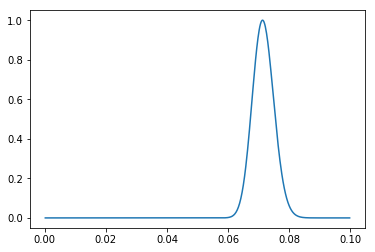

In [23]:
plt.plot(np.array([(i*0.1/bins) for i in range(1,bins)]),np.exp(r-max(r)))
plt.show()

In [32]:
rScaled = 10**(r-max(r))
rNormalised = rScaled/sum(rScaled)
rDistribution = np.cumsum(rNormalised)
print(np.where(rDistribution>0.025))
print(np.where(rDistribution<0.975))

(array([334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
       360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372,
       373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385,
       386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398,
       399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437,
       438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450,
       451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463,
       464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476,
       477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489,
       490, 491, 492, 493, 494, 495, 496, 497, 498]),)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
       

In [23]:
rVal = [(i*0.1/bins) for i in range(1,bins)]
rVal[334:378]

[0.067,
 0.06720000000000001,
 0.0674,
 0.06760000000000001,
 0.0678,
 0.068,
 0.0682,
 0.0684,
 0.06860000000000001,
 0.0688,
 0.069,
 0.0692,
 0.0694,
 0.06960000000000001,
 0.0698,
 0.07,
 0.0702,
 0.0704,
 0.07060000000000001,
 0.0708,
 0.071,
 0.0712,
 0.0714,
 0.07160000000000001,
 0.0718,
 0.072,
 0.0722,
 0.0724,
 0.07260000000000001,
 0.0728,
 0.073,
 0.0732,
 0.0734,
 0.07360000000000001,
 0.07379999999999999,
 0.074,
 0.0742,
 0.07440000000000001,
 0.07460000000000001,
 0.07479999999999999,
 0.075,
 0.0752,
 0.07540000000000001,
 0.07560000000000001]

In [24]:
print(0.067/0.12)
print(0.076/0.12)

0.5583333333333333
0.6333333333333333
